## Data Preprocessing

Converting cleaned data into the correct format for the SASRec model

In [1]:
import pandas as pd
import numpy as np

In [2]:
# read in cleaned Amazon beauty data
# product interactions are already sorted in temporal order
beauty = pd.read_csv('../assets/beauty23_clean.csv')
beauty.head()

,usr,prod
0,AFSKPY37N3C43SOI5IEXEK5JSIYA,B00JMDPK8S
1,AFSKPY37N3C43SOI5IEXEK5JSIYA,B01M7UMAUG
2,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07J3GH1W1
3,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07GDQPG12
4,AFSKPY37N3C43SOI5IEXEK5JSIYA,B07W397QG4


In [3]:
# assign integer identifier to users
usr_ind = beauty.groupby('usr', sort=False).count()
usr_ind = usr_ind.assign(ind_usr=np.arange(1,usr_ind.shape[0]+1))['ind_usr']
usr_ind

# assign integer identifier to products
prod_ind = beauty.groupby('prod', sort=False).count()
prod_ind = prod_ind.assign(ind_prod=np.arange(1,prod_ind.shape[0]+1))['ind_prod']

df = beauty.merge(usr_ind, left_on='usr', right_index=True)
df = df.merge(prod_ind, left_on='prod', right_index=True, sort=False)
df = df[['ind_usr', 'ind_prod']]
df.columns = ['usr', 'prod']
df.head()

,usr,prod
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5


In [4]:
# # save to txt file
df.to_csv('beauty23.txt', index=False, header=False)

## Training

The Training was completed in a GPU environment with the following parameters:

In [5]:
### training ###


# # hidden_units = 32

# !python main.py \
# --dataset=beauty23 \
# --train_dir=hidden32 \
# --hidden_units=32 \
# --maxlen=50 \
# --dropout_rate=0.5 \
# --device=cuda


# # hidden_units = 64

# !python main.py \
# --dataset=beauty23 \
# --train_dir=hidden64 \
# --hidden_units=64 \
# --maxlen=50 \
# --dropout_rate=0.5 \
# --device=cuda


# # hidden_units = 128

# !python main.py \
# --dataset=beauty23 \
# --train_dir=hidden128 \
# --hidden_units=128 \
# --maxlen=50 \
# --dropout_rate=0.5 \
# --device=cuda

## Testing

The below cells will test the trained SASRec models on the test set.

In [6]:
# test SASRec with hidden_units=32

!python main.py \
--device=cpu \
--dataset=beauty23 \
--train_dir=hidden32 \
--state_dict_path='beauty23_hidden32/SASRec.epoch=1000.lr=0.001.layer=2.head=1.hidden=32.maxlen=50.pth' \
--inference_only=true \
--maxlen=50 \
--hidden_units=32 \
--dropout_rate=0.5


average sequence length: 7.42
..........test (NDCG@10: 0.3148, HR@5: 0.3505, HR@10: 0.4479)
Done


In [7]:
# test SASRec with hidden_units=64

!python main.py \
--device=cpu \
--dataset=beauty23 \
--train_dir=hidden64 \
--state_dict_path='beauty23_hidden64/SASRec.epoch=1000.lr=0.001.layer=2.head=1.hidden=64.maxlen=50.pth' \
--inference_only=true \
--maxlen=50 \
--hidden_units=64 \
--dropout_rate=0.5


average sequence length: 7.42
..........test (NDCG@10: 0.3072, HR@5: 0.3525, HR@10: 0.4270)
Done


In [8]:
# test SASRec with hidden_units=128

!python main.py \
--device=cpu \
--dataset=beauty23 \
--train_dir=hidden128 \
--state_dict_path='beauty23_hidden128/SASRec.epoch=1000.lr=0.001.layer=2.head=1.hidden=128.maxlen=50.pth' \
--inference_only=true \
--maxlen=50 \
--hidden_units=128 \
--dropout_rate=0.5


average sequence length: 7.42
..........test (NDCG@10: 0.2760, HR@5: 0.3078, HR@10: 0.3813)
Done


### Results
Visualizing performance of the three models:

In [9]:
import matplotlib.pyplot as plt

In [12]:
dims = [32, 64, 128]
ndcg10 = [0.3148, 0.3072, 0.2760]
hr5 = [0.3505, 0.3525, 0.3078]
hr10 = [0.4479, 0.4270, 0.3813]

metrics = pd.DataFrame()
metrics['dim'] = dims
metrics = metrics.set_index('dim')
metrics['NDCG@10'] = ndcg10
metrics['HR@5'] = hr5
metrics['HR@10'] = hr10
metrics

,NDCG@10,HR@5,HR@10
dim,,,
32,0.3148,0.3505,0.4479
64,0.3072,0.3525,0.4270
128,0.2760,0.3078,0.3813


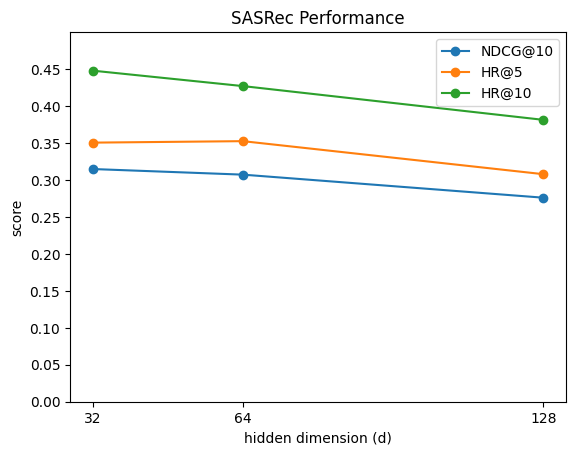

In [15]:
plt.plot(metrics.index, 'NDCG@10', data=metrics, marker='o', label='NDCG@10')
plt.plot(metrics.index, 'HR@5', data=metrics, marker='o', label='HR@5')
plt.plot(metrics.index, 'HR@10', data=metrics, marker='o', label='HR@10')
plt.title('SASRec Performance')
plt.xticks(metrics.index)
plt.ylim([0,0.5])
plt.yticks(np.arange(0, 0.5, step=0.05))
plt.xlabel('hidden dimension (d)')
plt.ylabel('score')
plt.legend()
plt.show()